# Homework 2

29 points

## Due March 12, end of the day

**Collaboration statement:**

In [4]:
import Test

## 1. Associative operations

Two of the most important primitive operations in distributed memory programming are 
**reduce**, which takes a binary operation $\otimes$ and a distributed array $A$ with one value on each produces a single value

$$r = (\dots((A[1]\otimes A[2])\otimes A[3])\dots \otimes A[p]),$$

In [5]:
reduce(*,[1,2,3,4,5,6])

720

and **scan** (aka prefix sum), which takes the same inputs and produces an array $B$ with the same layout as $A$ such that

$$
\begin{aligned}
B[1] &= A[1], \\
B[2] &= B[1] \otimes A[2], \\
B[3] &= B[2] \otimes A[3], \\
&\vdots \\
B[p] &= B[p-1] \otimes A[p].
\end{aligned}$$

(In Julia this is called `accumulate`, but we will stick to the parallel programming notation and so we define it as an alias here

In [6]:
scan = accumulate

accumulate (generic function with 1 method)

In [7]:
scan(*,[1,2,3,4,5,6])

6-element Array{Int64,1}:
   1
   2
   6
  24
 120
 720

(Note: It's also useful to define an exclusive scan or **exscan**, which takes an initial value $i_0$ and produces an array $B$ with the same layout as $A$ such that

$$
\begin{aligned}
B[1] &= i_0, \\
B[2] &= B[1] \otimes A[1], \\
B[3] &= B[2] \otimes A[2], \\
&\vdots \\
B[p] &= B[p-1] \otimes A[p-1].)
\end{aligned}$$

exscan(op, A, i0) = accumulate(op, cat([i0],A[2:end],dims=1))

In [8]:
exscan(op, A, i0) = accumulate(op, cat([i0],A[1:(end-1)],dims=1))

exscan (generic function with 1 method)

Fast parallel algorithms for these primitives require $\otimes$ to be associative: for every $a, b, c$,

$$(a \otimes b) \otimes c = a \otimes (b \otimes c).$$

**Show whether the following two operations are associative when applied to positive real numbers.**

You can show that an operation *is* associative by expanding $(a \otimes b) \otimes c$ and expanding $a \otimes (b \otimes c)$ and showing that they are the same expression.

You can show that an operation *is not* associative by finding specific inputs
$a$, $b$, and $c$ for which $(a \otimes b) \otimes c \neq a \otimes (b \otimes c).$

### a (2 points). $a \otimes b = (\max\{a,b\}) a$

This function is not associative. Let $a = 2$, $b=1$, $c=1$. Then $$(a \otimes b) \otimes c = (2 \otimes 1) \otimes 1 = (\max\{2,1\})2 \otimes 1 = 4 \otimes 1 = (\max\{4,1\})4 = 16$$
However, 
$$a \otimes (b \otimes c) = 2 \otimes (1 \otimes 1) = 2 \otimes (\max\{1,1\})1 = 2 \otimes 1 = (\max\{2, 1\})2 = 4$$ Clearly $16 \neq 4$, and so the operation is not associative.

### b (2 points). $a \otimes b = \frac{1}{\frac{1}{a} + \frac{1}{b}}$

This operation is associativate. 

$$(a \otimes b) \otimes c = \left(\frac{1}{\frac{1}{a}+\frac{1}{b}}\right) \otimes c = \frac{1}{\left(\frac{1}{\frac{1}{\frac{1}{a}+\frac{1}{b}}}\right)+\frac{1}{c}} = \frac{1}{\frac{1}{a}+\frac{1}{b}+\frac{1}{c}}$$

$$a \otimes (b \otimes c) = a \otimes \left(\frac{1}{\frac{1}{b} + \frac{1}{c}}\right) = \frac{1}{\frac{1}{a} + \left(\frac{1}{\frac{1}{\frac{1}{b} + \frac{1}{c}}}\right)} = \frac{1}{\frac{1}{a} + \frac{1}{b} + \frac{1}{c}}
$$ 

As we can see, $$(a \otimes b) \otimes c = a \otimes (b \otimes c)$$ so the operation is associative.

## 2. Associative, non-commutative operations

Not all inputs to associative operations are numbers.  Matrices with matrix multiplication are another example of an associative operation.

### a (1 point).

Even though matrix multiplication is *associative* (allowing for fast `reduce` and `scan`), it is not *commutative*, meaning $a \otimes b \neq b \otimes a$.  Give an example of two matrices that do not commute.

In [9]:
function two_noncommuting_matrices()::Tuple{Matrix{Int64},Matrix{Int64}}
    A = [1 1; 1 0]
    B = [1 0; 1 1]
    return A,B
    throw(MethodError)
end
A, B = two_noncommuting_matrices()

([1 1; 1 0], [1 0; 1 1])

In [10]:
A, B = two_noncommuting_matrices()
Test.@test A * B != B * A

Test Passed

### b (2 points).

The implementations of `MPI_Reduce` and `MPI_Scan` are like `reduce` and `scan`: they take as inputs data (although it is distributed, not in a single array accessible to all processes), and an associative binary operation.  But implementations of `MPI_Reduce` and `MPI_Scan` may have to be implemented in terms of point-to-point messages sent between processors.  Consider the following two communication patterns that have been proposed to implement `MPI_Reduce` for an arbitrary associative operation $\otimes$ to reduce data $A$ that is spread across 8 processes:

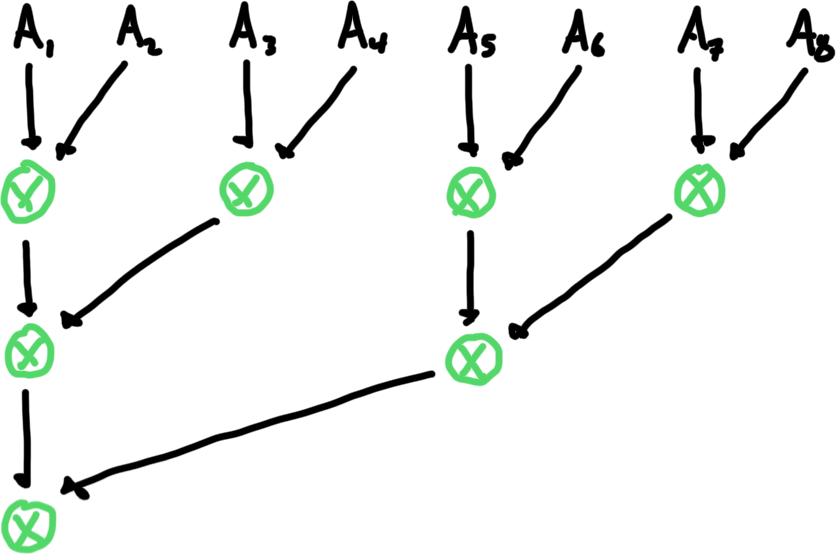

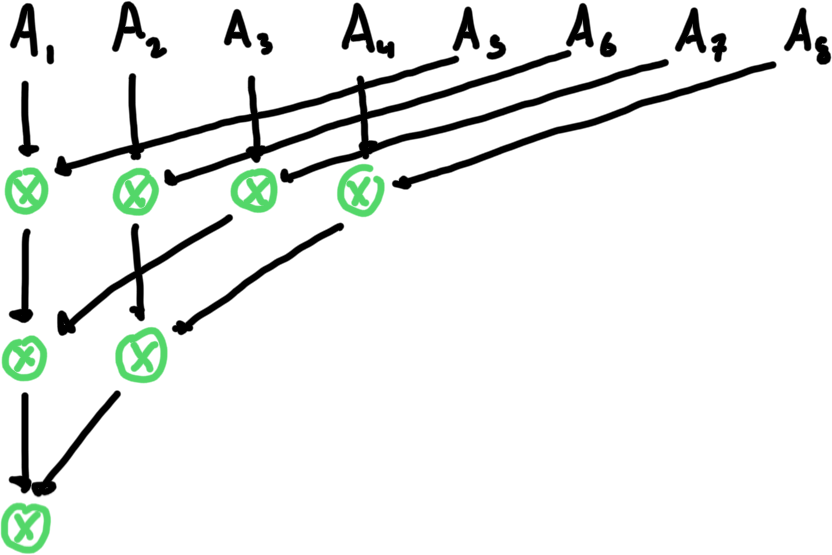

Which of these two communication patterns is a correct implementation of `reduce(op, A)`? Both? Neither? Just the first?  Just the second?  Justify your answer.

The first implementation can be written as $$((A_1 \otimes A_2) \otimes (A_3 \otimes A_4)) \otimes ((A_5 \otimes A_6) \otimes (A_7 \otimes A_8)) \\ (((((((A_1 \otimes A_2) \otimes A_3) \otimes A_4) \otimes A_5) \otimes A_6) \otimes A_7) \otimes A_8)$$ while the second can be written as $$((A_1 \otimes A_5) \otimes (A_3 \otimes A_7)) \otimes ((A_2 \otimes A_6) \otimes (A_4 \otimes A_8)) \\ (((((((A_1 \otimes A_5) \otimes A_3) \otimes A_7) \otimes A_2)\otimes A_6)\otimes A_4) \otimes A_8)$$

We can see that the first implementation correctly reduces to the definition of the reduce operation by using the associative nature of $\otimes$. The second implementation does not. If $\otimes$ was also commutative (such as the case with scalar multiplication) then the second implementation could be rearagned into the correct form for reduce. The operator $\otimes$, though, is not nesscarly a commuting operator, and thus the second implementation will not correctly reduce for every associtive opperator. 

## About the remainder of this homework

In this homework we are learning about distributed algorithms that build on `reduce` and `scan`.

- Because MPI let's you define custom data types and custom operations, [`MPI_Reduce`](https://www.mpich.org//static/docs/v3.1/www3/MPI_Reduce.html), [`MPI_Allreduce`](https://www.mpich.org//static/docs/v3.1/www3/MPI_Allreduce.html), [`MPI_Scan`](https://www.mpich.org//static/docs/v3.1/www3/MPI_Scan.html), and [`MPI_Exscan`](https://www.mpich.org//static/docs/v3.1/www3/MPI_Exscan.html) can be used on a variety of problems: the user doesn't have to program any communication, just the local operations that are performed by each MPI process.

- In past versions of this class, this homework assignment has asked users to design (pencil & paper) algorithms to accomplish particular tasks use `reduce` or `scan`.  I found that many students tried to write algorithms that would not have worked in practice.  The most common reason is that they did not think about *where* the results of calculations are stored: an important thing to know about a distributed memory algorithm.

- We cannot use `MPI.jl` in a jupyter notebook.  Instead, you will design algorithms that act like MPI algorithms:

1. Every input will either be a *processor vector* (`Vector{T}` with length `p > 1`) if it represents distributed data, or it will be *root data* that only has a copy in the root process.

2. You can simulate `MPI_Bcast` to broadcast data from the root processes to all processes with `bcast`:

In [11]:
bcast(data, p) = fill(data, (p,))

bcast (generic function with 1 method)

As an example, here we broadcast the matrix $\begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix}$ to 10 processes.  Note that the result is *not* a 3 dimensional array of type `Array{Float64,3]`, it is a 1 dimensional array of matrices, `Array{Array{Float64,2},1}`:

In [12]:
A = bcast([[1.,0.] [0.,1.]], 10)

10-element Array{Array{Float64,2},1}:
 [1.0 0.0; 0.0 1.0]
 [1.0 0.0; 0.0 1.0]
 [1.0 0.0; 0.0 1.0]
 [1.0 0.0; 0.0 1.0]
 [1.0 0.0; 0.0 1.0]
 [1.0 0.0; 0.0 1.0]
 [1.0 0.0; 0.0 1.0]
 [1.0 0.0; 0.0 1.0]
 [1.0 0.0; 0.0 1.0]
 [1.0 0.0; 0.0 1.0]

3. In addition to `bcast`, `reduce`, and `scan`, you are allowed to write a function that acts on the data local to each process `f()` and apply it to a collection of processor vectors using julia's *dot-broadcasting*, `f.()`. As an example, here we make another processor vector of matrices `B`, a local function that computes `X + Y.T`, and apply it to the processor vectors `A` and `B`

In [13]:
B = [rand(2,2) for i = 1:10]

10-element Array{Array{Float64,2},1}:
 [0.05478947897093556 0.9988387450083449; 0.19852654654917834 0.7649990086110072]
 [0.8680328935777029 0.334382891068117; 0.00526195087366732 0.5660140877543316]
 [0.5884348719454837 0.8582191584633696; 0.9066320065512523 0.41809035263334926]
 [0.587749026127732 0.23372153572470356; 0.22715294796483843 0.09756365491714347]
 [0.5299282272999621 0.16331932544345706; 0.8720224348080821 0.49633001142236344]
 [0.6343109221386543 0.5285642803491402; 0.2692477483653064 0.418523837074096]
 [0.6026418277316437 0.17731024204066181; 0.6727724862529707 0.5585180503190066]
 [0.3777087643346546 0.19550803282266105; 0.997443102582684 0.4946869495654844]
 [0.44577104005109924 0.5195571322659955; 0.07005932570733031 0.935785923147477]
 [0.059882035684506896 0.3910630544825515; 0.5573196714975706 0.85356419398392]

In [14]:
function x_plus_y_transpose(x, y)
    return x + y'
end

x_plus_y_transpose (generic function with 1 method)

In [15]:
C = x_plus_y_transpose.(A,B)

10-element Array{Array{Float64,2},1}:
 [1.0547894789709356 0.19852654654917834; 0.9988387450083449 1.7649990086110072]
 [1.8680328935777029 0.00526195087366732; 0.334382891068117 1.5660140877543316]
 [1.5884348719454837 0.9066320065512523; 0.8582191584633696 1.4180903526333493]
 [1.587749026127732 0.22715294796483843; 0.23372153572470356 1.0975636549171435]
 [1.5299282272999621 0.8720224348080821; 0.16331932544345706 1.4963300114223634]
 [1.6343109221386543 0.2692477483653064; 0.5285642803491402 1.418523837074096]
 [1.6026418277316437 0.6727724862529707; 0.17731024204066181 1.5585180503190066]
 [1.3777087643346546 0.997443102582684; 0.19550803282266105 1.4946869495654844]
 [1.4457710400510992 0.07005932570733031; 0.5195571322659955 1.935785923147477]
 [1.059882035684507 0.5573196714975706; 0.3910630544825515 1.85356419398392]

## 3. Polynomial evaluation

Read section 1.5.2 of the old course notes about an algorithm for evaluating a polynomial in parallel.

Suppose the array $A = [a_0, \dots, a_{p-1}]$ of coefficients has already been distributed,
and the location $x$ has been broadcast ([MPI_Bcast](https://www.mpich.org/static/docs/v3.2/www3/MPI_Bcast.html)) from a single process.

In [16]:
p = 15
A = randn(p)
x = rand()

0.7880213914368666

One serial algorithm to evaluate the polynomial is the following:

In [17]:
function serial_poly_eval(A, x)
    y = A[1]
    z = x
    for i = 2:length(A)
        y += A[i] * z
        z *= x
    end
    return y
end

serial_poly_eval (generic function with 1 method)

In [18]:
serial_poly_eval(A, x)

2.2272331914665093

### a (2 points).

After reading section 1.5.2 of the old course notes, write the polynomial evaluation function described there using only `bcast`, `exscan`, `reduce`, and dot-broadcast functions.

In [19]:
function distributed_poly_eval(p::Int64, A::Vector{Float64}, x::Float64)::Float64
    # p: the number of processes
    # A: processor vector of distributed coefficients [a_0, a_1, ..., a_{p-1}]
    # x: point at which to evaluate
    # your code here
    x_dist = similar(A)
    x_dist[2:end] = bcast(x, p-1);
    x_dist[2:end] = exscan(*, x_dist[2:end], x)
    x_dist[1] = 1
    inner_sum = A.*x_dist
    return reduce(+, inner_sum)
end

distributed_poly_eval (generic function with 1 method)

In [20]:
p = 15
A = randn(p)
x = rand()

y_serial = serial_poly_eval(A, x)
y_distributed = distributed_poly_eval(p, A, x)
Test.@test abs(y_serial - y_distributed) < 1.e-8 * (abs(y_serial)+abs(y_distributed))

Test Passed

### b (3 points).

A second way to evaluate the polynomial is by Horner's rule:

$$ y = ((\dots((a_{p-1} x + a_{p-2}) x + a_{p-3})\dots)x + a_0)$$

Here is an implementation of Horner's rule, assuming the coefficents are listed in decreasing order, $[a_{p-1}, \dots, a_0]$

In [21]:
function serial_poly_eval_horner(Arev, x)
    y =  0.
    for i = 1:length(Arev)
        y = y * x + Arev[i] 
    end
    return y
end

serial_poly_eval_horner (generic function with 1 method)

In [22]:
p = 15
A = randn(p)
x = rand()

Arev = A[end:-1:1]
y_serial = serial_poly_eval(A, x)
y_serial_horner = serial_poly_eval_horner(Arev,x)
Test.@test abs(y_serial - y_serial_horner) < 1.e-8 * (abs(y_serial)+abs(y_serial_horner))

Test Passed

In [23]:
function make_matrix(a, x)
    return [x 0; a 1] 
end

function distributed_poly_eval_horner(p::Int64, Arev::Vector{Float64}, x::Float64)::Float64
    # p: the number of processes
    # Arev: processor vector of distributed coefficients in reverse order [a_{p-1}, a_{p-1}, ..., a_0]
    # x: point at which to evaluate
    #Distrubute x to each proc  
    x_dist = bcast(x, p)
    dist_matrix = make_matrix.(Arev, x_dist)
    
    y = reduce(*, dist_matrix)
    return y[2,1]
    #throw(MethodError)
end

distributed_poly_eval_horner (generic function with 1 method)

In [24]:
p = 15
Arev = randn(p)
x = rand()

y_serial = serial_poly_eval_horner(Arev, x)
y_distributed = distributed_poly_eval_horner(p, Arev, x)
Test.@test abs(y_serial - y_distributed) < 1.e-8 * (abs(y_serial)+abs(y_distributed))

Test Passed

## c (3 points).

Pretend `bcast`, `exscan` and `reduce` have the communication complexities described in the notes.  Compare the communication complexity of your implementations of `distributed_poly_eval` and `distributed_poly_eval_horner`: which one is faster?  **Note:** your answer will depend on the relative values
of the coefficients $\tau$ and $\mu$ in the Hockney model $\tau + \mu m$ for the communication of a model of size $m$.

In `distributed_poly_eval`, the value $x$ is first distrubuted by a `bcast` call, then each power is computed with an `exscan` call. Individual terms are calculated by each processor localy, and then a final call to `reduce` to sum over all the processes. We know that `bcast`, `exscan` and `reduce` all have the complexity $\Theta(\tau \log p + \mu m \log p)$ for a latency $\tau$, an inverse bandwidth of $\mu$ and a message size $m$. The runtime of `distributed_poly_eval` is then $\Theta(3(\tau \log p + \mu m \log p))$.

For `distributed_poly_eval_horner` only two distributed calls are made, an initial `bcast` to distrubit the $x$ value, and then a `reduce` to compute the sum. However, in the final reduce, a $2x2$ array is being sent across processors, not just a scalar value, so in this case, the computational complexity of the `reduce` call is now $\Theta(\tau \log p + \mu (4m) \log p)$. The final complexity of the `distrubuted_poly_eval_horner` function is $\Theta(\tau \log p + \mu m \log p) + \Theta(\tau \log p + \mu (4m) \log p) = \Theta(2\tau \log p + 5 \mu m log p)$ 

We can see that if the inverse bandwidth $\mu$ is much larger than $\tau$, then the original `distributed_poly_eval` will be faster. However, in most cases, the dominating term will be the latency of communication, $\tau$ and so the `distributed_poly_eval_horner` will be the faster function.

## 4 (3 points). Nested parentheses

A sequence of nested parenthesis is said to be well-formed if

1. There are an equal number of left and right parenthesis and
2. each right parenthesis is matched by a left parenthesis that occurs to its left in the sequence.

For example, `( ( ( ) ( ) ) ( ) )` is well-formed but `( ) ) (` is not.

There is a nested parenthesis sequence of length $p$ distributed across $p$ processors. Write a distributed algorithm using `scan`, `reduce` and dot-broadcasted functions to determine if it is well-formed.

In [25]:
#A left parenthesis is assigned a value of +1, while a right parenthesis is assigned -1
#The sum of these values must be 0 for there to be an equal number of left and right parentheses
# and any partial sum can not be negative (i.e. we can not have more right parntheses then left at any point in the sequence)
function p2v(A)
   if A == '('
       return 1
   else 
       return -1
   end
end


function distributed_parentheses_check(p, ranks, sequence)
    sequence = p2v.(sequence)
    scan_result = scan(+, sequence)
    #Determin for each processor if the intermmediate value is negative
    is_neg = scan_result .< 0
    valid_seq = reduce(==, is_neg) #All values should be false
    return valid_seq && scan_result[p] == 0 #If we never have more rights than lefts at any p, and all the values sum to 0, tis a valid sequence 
    
end

distributed_parentheses_check (generic function with 1 method)

In [26]:
using Random

function generate_valid_sequence(npairs)
    seq = ['(',')']
    for i = 1:(npairs-1)
        rs = rand(0:2*i,2)
        rmin = minimum(rs)
        rmax = maximum(rs)
        seq = cat(seq[1:rmin],'(',seq[rmin+1:rmax],')',seq[rmax+1:end];dims=1)
    end
    return seq
end

function generate_invalid_sequence(npairs)
    start = fill('(',npairs-1)
    stop = fill(')',npairs+1)
    C = cat(start,stop;dims=1)
    i = Random.randperm(2*npairs)
    C[i] = C
    return C
end

p = 1000
ranks = [i for i=1:p]
ntests = 100
for test = 1:ntests
    C = generate_valid_sequence(div(p,2))
    isvalid = distributed_parentheses_check(p, ranks, C)
    Test.@test isvalid == true
    X = generate_invalid_sequence(div(p,2))
    isvalid = distributed_parentheses_check(p, ranks, X)
    Test.@test isvalid == false
end
ans

distributed_parentheses_check (generic function with 1 method)

## 5 (3 points). Rational recurrence

The following sequential function is a recurrence, but it is rational rather than linear or affine.

In [27]:
function rational_recurrence(A)
    x = similar(A)
    x[1] = A[1]
    for i = 2:length(A)
        x[i] = A[i] / x[i-1]
    end
    return x
end

rational_recurrence (generic function with 1 method)

Write a distributed function using `scan` that computes the same recurrence.

In [28]:
function distributed_rational_recurrence(p, A::Vector{Float64})::Vector{Float64}
    # p: the number of processes
    # A: list of coefficients [a_1, ..., a_p]
    # your code here
   #Invert every even element

     A[2:2:p] = 1 ./(A[2:2:p])
     result = scan(*, A)
     result[2:2:p] = 1 ./(result[2:2:p])
    return result
end

distributed_rational_recurrence (generic function with 1 method)

In [29]:
p = 1000
A = rand(p)
V_serial = rational_recurrence(A)
V_distributed = distributed_rational_recurrence(p, A)
Test.@test maximum(abs.(V_serial - V_distributed)) < 1.e-8 * (maximum(abs.(V_serial)) + maximum(abs.(V_distributed)))

Test Passed

## 6 (3 points). Forward variation

Let $A$ be an array of integers of size $p$.  For each index $k$, we want to calculate the maximum *forward variation* for the subarray $A[1:k]$:

$$ F[k] := \max_{i\leq j \leq k} A[j] - A[i]. $$

Here is a (suboptimal) sequential algorithm.

In [30]:
function forward_variation(A)
    p = length(A)
    F = similar(A)
    for k = 1:p
        F[k] = -Inf
        for j = 1:k
            for i = 1:j
                F[k] = max(F[k], A[j] - A[i])
            end
        end
    end
    return F
end

forward_variation (generic function with 1 method)

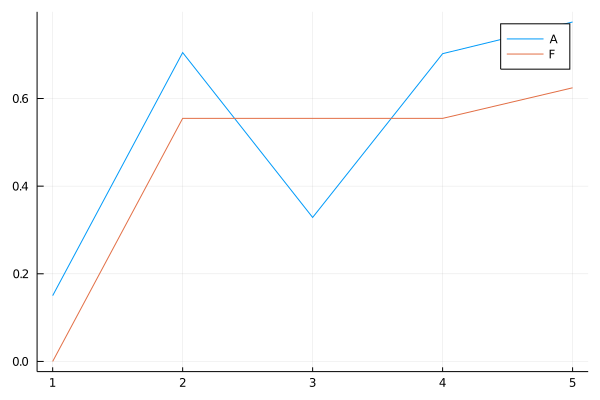

In [31]:
p = 5
A = rand(p)
F = forward_variation(A)

using Plots

plot(A, label="A")
plot!(F, label="F")

Write a distributed algorithm using only `scan` and dot-broadcast functions to compute the forward variation.

In [32]:
function init(a)
   return [a;0] 
end

function get_max(a)
   return a[2] 
end

function op(a,b)
   return [a[1]; max(a[2],a[1]-b[1])] 
end


function distributed_forward_variation(p, A::Vector{Float64})::Vector{Float64}
    # p: the number of processes
    # A: list of numbers [a_1, ..., a_p]
    # your code here
    #Init each data type
    data = init.(A)
     #Holds each procs max value 
    maxs = Vector{Float64}(undef, p)
    maxs[1] = 0
    for i = 1:p
        tmp_data = scan(op, data[i:-1:1])
        maxs[i] = tmp_data[i][2]
    end
    return scan(max, maxs)
end

distributed_forward_variation (generic function with 1 method)

In [33]:
p = 1000
A = rand(p)
F_serial = forward_variation(A)
F_distributed = distributed_forward_variation(p, A)
Test.@test all(F_serial .== F_distributed)

Test Passed

## 7 (5 points). Tree accumulation

Suppose we have a molecule that is represented by a tree of bonds $(u \to v)$ that connect atoms $u$ and $v$.  Sometimes, if we know the location of $v$ and the type of bond between $u$ and $v$, that is enough information to figure out the position of $u$. This means that we can use tree accumulation to determine the location of every atom in the particle.

This code generates a random collection of "atoms" that are connected by offsets in a tree pattern.

In [34]:
function generate_random_molecule(natoms)
    parents = zeros(Int64, natoms)
    for j = 2:natoms
        parents[j] = rand(1:(j-1))
    end
    relative_positions = randn(natoms, 3)
    return (parents, relative_positions)
end

generate_random_molecule (generic function with 1 method)

Here is a serial algorithm for computing the absolute positions from the relative positions.

In [35]:
function serial_molecule_absolute_positions(natoms, parents, relative_positions)
    absolute_positions = similar(relative_positions)
    absolute_positions[1,:] = relative_positions[1,:]
    for i = 2:natoms
        p = parents[i]
        absolute_positions[i,:] = absolute_positions[p,:] .+ relative_positions[i,:]
    end
    return absolute_positions
end

serial_molecule_absolute_positions (generic function with 1 method)

Here is an algorithm for computing the Euler tour of the tree.

In [36]:
first = "first"
last = "last"
middle = "middle"
leaf = "leaf"

function euler_tree_tour(parents)
    n = length(parents)
    edges = Vector{NTuple{3,Int64}}(undef, 2*(n-1))
    for i = 1:n-1
        p = parents[i+1]
        edges[2*(i-1)+1] = (p,i+1,2*(i-1)+1)
        edges[2*i] = (i+1,p,2*i)
    end
    first = Vector{Int64}(undef, n)
    fill!(first, -1)
    sort!(edges)
    for i = 1:2*(n-1)
        edge = edges[i]
        if i == 1
            first[edge[1]] = i
        else
            preedge = edges[i-1]
            if preedge[1] != edge[1]
                first[edge[1]] = i
            end
        end
    end
    succ = Vector{Int64}(undef, 2*(n-1))
    etypes = Vector{Symbol}(undef, 2*(n-1))
    for i = 1:2*(n-1)
        u, v, e = edges[i]
        if u < v
            if (v == n || first[v+1] == first[v] + 1)
                succ[e] = edges[first[v]][3]
                etypes[e] = :leaf
            else
                succ[e] = edges[first[v]+1][3]
                etypes[e] = :first
            end
            next = edges[i+1]
            if next[1] == u
                succ[e+1] = next[3]
                etypes[e+1] = :middle
            else
                succ[e+1] = edges[first[u]][3]
                etypes[e+1] = :last
                if succ[e+1] == 1
                    succ[e+1] = 0
                end
            end
        end 
    end
    pos = ones(Int64,2*(n-1))
    for s = 1:ceil(Int64,log2(2*(n-1)))
        newpos = copy(pos)
        newsucc = similar(succ)
        for i = 1:2*(n-1)
            s = succ[i]
            if s > 0
                newpos[s] += pos[i]
                newsucc[i] = succ[s]
            else
                newsucc[i] = 0
            end
        end
        pos = newpos
        succ = newsucc
    end
    tour = Vector{Int64}(undef,2*n-1)
    tourtype = Vector{Symbol}(undef,2*n-1)
    tour[1] = 1
    tourtype[1] = :first
    for i = 1:2*(n-1)
        u, v, e = edges[i]
        p = pos[e]
        tour[p+1] = v
        tourtype[p+1] = etypes[e]
    end
    return tour, tourtype
end

euler_tree_tour (generic function with 1 method)

Here is what the Euler tour looks like: notice that each vertex in the tour can be a `:first`, `:middle`, or `:last` if the vertex has descendants, or it is a `:leaf`.

In [37]:
euler_tree_tour(generate_random_molecule(10)[1])

([1, 2, 3, 4, 8, 10, 8, 4, 3, 2, 6, 2, 1, 5, 7, 9, 7, 5, 1], [:first, :first, :first, :first, :first, :leaf, :last, :last, :last, :middle, :leaf, :last, :middle, :first, :first, :leaf, :last, :last, :last])

Following the description in the "Applications of Prefix Sums" slides,
write a function that takes the Euler tour of the molecule tree and the relative
positions of the atoms and computes the absolute positions of the atoms.  The absolute
positions should be stored in a vector of the same length as the Euler tour, and it is
only necessary for the absolute position to be correct if the type of the vertex in the Euler tour is `:first` or `:leaf`.  Your function should only use `scan` and dot-broadcast functions.

In [43]:
function init(et, tt, trp)
    if(tt == :first)
        return trp 
    end
    if(tt == :last)
         return (-trp[1], -trp[2], -trp[3])
     end
     return (0,0,0)
end

function op(a,b)
     #Compute pos of b from parent a
    return a[:].+b[:]
end

function add_leafs(tour_type, parent_pos, leaf_pos)
   if(tour_type == :leaf)
        return op(parent_pos, leaf_pos)
   end
   return parent_pos
end



function distributed_absolute_positions(p,
                                        euler_tour_vertices::Vector{Int64},
                                        tour_types::Vector{Symbol},
                                        tour_relative_positions::Vector{NTuple{3,Float64}}
                                        )::Vector{NTuple{3,Float64}}
    

    data = init.(euler_tour_vertices, tour_types, tour_relative_positions)
    pos = scan(op, data)
    tmp = add_leafs.(tour_types, pos, tour_relative_positions)
    return tmp
    
end
    

distributed_absolute_positions (generic function with 1 method)

Plotting serial vs. distributed absolute positions


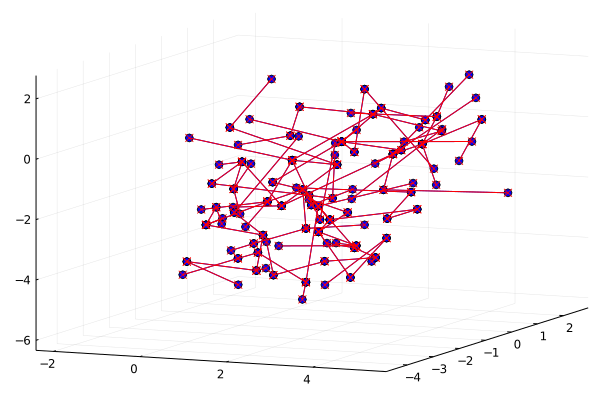

In [45]:
natoms = 100
parents, relative_positions = generate_random_molecule(natoms)
abspos_serial = serial_molecule_absolute_positions(natoms, parents, relative_positions)
euler_tour_vertices, tour_types = euler_tree_tour(parents)
tour_relative_positions = Vector{NTuple{3,Float64}}(undef, 2*natoms-1)
for i = 1:2*natoms-1
    x = relative_positions[euler_tour_vertices[i],1:3]
    tour_relative_positions[i] = (x[1], x[2], x[3])
end

tour_abs_positions = distributed_absolute_positions(natoms,
                                                    euler_tour_vertices,
                                                    tour_types,
                                                    tour_relative_positions)
abspos_distributed = similar(abspos_serial)
for i = 1:2*natoms-1
    if tour_types[i] == :first || tour_types[i] == :leaf
        abspos_distributed[euler_tour_vertices[i],1:3] .= tour_abs_positions[i]
    end
end

plot(legend=false)
for i = 2:natoms
    v = abspos_serial[i,1:3]
    vp = abspos_serial[parents[i],1:3]
    plot!([v[1], vp[1]],[v[2], vp[2]],[v[3], vp[3]], color=:blue, marker=:o)
end
for i = 2:natoms
    v = abspos_distributed[i,1:3]
    vp = abspos_distributed[parents[i],1:3]
    plot!([v[1], vp[1]],[v[2], vp[2]],[v[3], vp[3]], color=:red, marker=:x)
end
println("Plotting serial vs. distributed absolute positions") # nbgrader needs me to have some text, apparently
plot!()

In [40]:
using LinearAlgebra

Test.@test norm(abspos_serial - abspos_distributed) < 1.e-8 * (norm(abspos_serial)+norm(abspos_distributed))

Test Passed